In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
# Load the dataset
data = pd.read_csv('edata.csv')

In [5]:
# Convert Unix Timestamp to datetime (UTC)
data['date_time'] = pd.to_datetime(data['Timestamp'], unit='s')

In [6]:
# Select the necessary columns and rename them for consistency
data = data[['date_time', 'Mag', 'Depth km']]
data.rename(columns={'Mag': 'mag', 'Depth km': 'depth'}, inplace=True)

In [7]:
# Drop any rows with missing values
data.dropna(inplace=True)

## Normalize Magnitude Values
Scale the 'mag' column to a range of 0 to 1 using MinMaxScaler to improve model performance.
Normalization is important for LSTM networks to ensure efficient training and avoid dominance of higher-valued features.

In [8]:
# Normalize the 'mag' (magnitude) column
scaler = MinMaxScaler()
data[['mag']] = scaler.fit_transform(data[['mag']])

## Create LSTM Training Dataset
Convert the time series data into sequences for LSTM training, using a specified time step window.
This function slides over the dataset, taking sequences of `time_steps` length as inputs (Xs) and the corresponding next value as output (ys).
Depth values are also stored separately to be used as an additional feature.

In [9]:
# Use the actual depth values from the dataset (no random values)
# If you wish, you can also scale the depth column separately

# Function to create dataset for LSTM training
def create_dataset(X, y, depth, time_steps=10):
    Xs, ys, depths = [], [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
        depths.append(depth.iloc[i + time_steps])
    return np.array(Xs), np.array(ys), np.array(depths)

In [10]:
TIME_STEPS = 10
X, y, depth = create_dataset(data[['mag']], data['mag'], data['depth'], TIME_STEPS)

## Split Data into Training and Testing Sets
Splitting ensures that the model is trained on one part of the dataset and tested on unseen data to evaluate its performance.
Here, 80% of the data is used for training and 20% for testing.

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, depth_train, depth_test = train_test_split(
    X, y, depth, test_size=0.2, random_state=42
)

## Define the LSTM Model
The model consists of two separate inputs:
1. `input_mag`: A sequence input for earthquake magnitudes processed through stacked LSTM layers.
2. `input_depth`: A single numerical input representing depth, processed through a dense layer.
Both inputs are concatenated before passing through the final dense output layer.

In [12]:
# Define the model's input layers
input_mag = Input(shape=(X_train.shape[1], X_train.shape[2]), name='input_mag')
input_depth = Input(shape=(1,), name='input_depth')

In [13]:
# Build LSTM layers for the magnitude input
lstm_mag = LSTM(units=128, return_sequences=True)(input_mag)
lstm_mag = LSTM(units=128, return_sequences=False)(lstm_mag)

In [14]:
# Dense layer to process the depth input
dense_depth = Dense(units=64, activation='relu')(input_depth)


In [15]:
# Concatenate the outputs from the LSTM and the depth branch
concatenated = concatenate([lstm_mag, dense_depth])

In [16]:
# Output layer
output = Dense(units=1)(concatenated)

In [17]:
# Create and compile the model
model = Model(inputs=[input_mag, input_depth], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

## Train the Model
Train the LSTM model using the training data with a validation split of 10%.
The model is trained for 200 epochs with a batch size of 64.

In [18]:
# Train the model
model.fit(
    {'input_mag': X_train, 'input_depth': depth_train},
    y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/200
338/338 [==============================] - 7s 18ms/step - loss: 0.3069 - val_loss: 0.0086
Epoch 2/200
338/338 [==============================] - 6s 17ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 3/200
338/338 [==============================] - 6s 17ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 4/200
338/338 [==============================] - 6s 17ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 5/200
338/338 [==============================] - 6s 18ms/step - loss: 0.0084 - val_loss: 0.0109
Epoch 6/200
338/338 [==============================] - 6s 17ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 7/200
338/338 [==============================] - 6s 18ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 8/200
338/338 [==============================] - 6s 18ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 9/200
338/338 [==============================] - 6s 18ms/step - loss: 0.0089 - val_loss: 0.0107
Epoch 10/200
338/338 [==============================] - 6s 18ms/step - loss: 0.009

## Predict Future Values
Use the trained model to predict future earthquake magnitudes based on the last available data points.
The function works iteratively by taking the last `time_steps` values, making a prediction, and updating the input sequence for the next step.

In [19]:
# Function to predict future values
def predict_future(model, X, depth, time_steps, future_steps):
    future_predictions = []
    current_batch = X[-1].reshape(1, time_steps, X.shape[2])
    current_depth = depth[-1]  # Get the last depth value
    for i in range(future_steps):
        future_pred = model.predict({
            'input_mag': current_batch,
            'input_depth': np.array([[current_depth]])
        })[0][0]
        future_predictions.append(future_pred)
        # Update the input sequence: shift left and add the new prediction at the end
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = future_pred
    return future_predictions

In [20]:
# Predict the next 60 time steps
future_predictions = predict_future(model, X_test, depth_test, TIME_STEPS, 60)

1/1 [==============================] - 0s 12ms/step


In [21]:
# Inverse-transform the predicted magnitude values back to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [22]:
print("Future Predictions:")
print(future_predictions)

Future Predictions:
[[3.7174528]
 [3.674605 ]
 [3.6834123]
 [3.6758153]
 [3.6947496]
 [3.772767 ]
 [3.8161795]
 [3.845661 ]
 [3.8588755]
 [3.8343587]
 [3.8688438]
 [3.8896554]
 [3.9167974]
 [3.9492674]
 [3.9855626]
 [4.0142746]
 [4.0384245]
 [4.0603476]
 [4.082433 ]
 [4.1084814]
 [4.133919 ]
 [4.1590567]
 [4.182765 ]
 [4.2041306]
 [4.222843 ]
 [4.239819 ]
 [4.255514 ]
 [4.2701015]
 [4.2835455]
 [4.2956448]
 [4.306393 ]
 [4.3158746]
 [4.324244 ]
 [4.3316684]
 [4.338281 ]
 [4.34417  ]
 [4.349403 ]
 [4.354047 ]
 [4.358161 ]
 [4.361806 ]
 [4.3650384]
 [4.3679037]
 [4.3704476]
 [4.372706 ]
 [4.374714 ]
 [4.376499 ]
 [4.3780837]
 [4.379495 ]
 [4.380748 ]
 [4.3818626]
 [4.3828506]
 [4.383733 ]
 [4.3845196]
 [4.385218 ]
 [4.3858395]
 [4.3863935]
 [4.3868837]
 [4.387325 ]
 [4.387713 ]
 [4.3880625]]


In [23]:
# Retrieve the actual magnitude values for comparison (last values from the dataset)
actual_values = data[['mag']].iloc[-len(future_predictions):]
# Inverse transform the actual values to match the original scale
actual_values = scaler.inverse_transform(actual_values)

In [24]:
# Calculate prediction errors (Actual - Predicted)
prediction_errors = actual_values - future_predictions

## Evaluate the Model
Evaluate the accuracy of predictions using error metrics:
- **MSE (Mean Squared Error)**: Measures average squared error.
- **RMSE (Root Mean Squared Error)**: Provides an error estimate in the same unit as the target variable.
- **MAE (Mean Absolute Error)**: Measures average absolute differences.

In [25]:
# Evaluate predictions using MSE, RMSE, and MAE
def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

mse, rmse, mae = evaluate_predictions(actual_values, future_predictions)
print("MSE (Mean Squared Error):", mse)
print("RMSE (Root Mean Squared Error):", rmse)
print("MAE (Mean Absolute Error):", mae)

MSE (Mean Squared Error): 0.9675337042228062
RMSE (Root Mean Squared Error): 0.9836329113153983
MAE (Mean Absolute Error): 0.8223957022031149


## Interpretation of Model Performance
- The MSE value (0.9675) indicates the average squared difference between actual and predicted values, meaning there is a moderate level of error.
- RMSE (0.9836) gives an idea of the standard deviation of the prediction errors, showing that the model's predictions deviate from actual values by approximately this amount.
- MAE (0.8224) suggests that on average, the predicted magnitudes differ from actual magnitudes by around 0.82 units.

These values indicate that while the model is making reasonable predictions, there is room for improvement, possibly by fine-tuning hyperparameters, increasing dataset size, or adding more relevant features.

## Visualize Results
Generate plots to compare actual vs predicted values and visualize prediction errors.

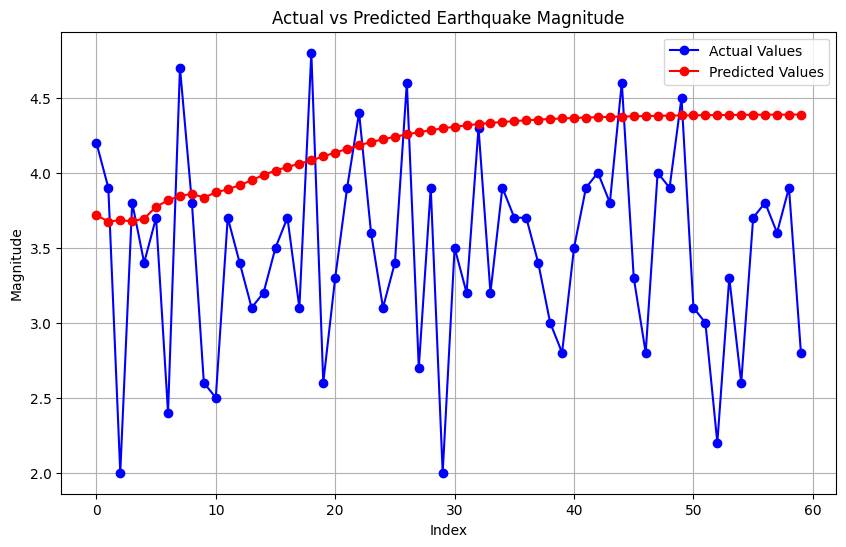

In [26]:
# Visualize the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', color='blue', marker='o')
plt.plot(future_predictions, label='Predicted Values', color='red', marker='o')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.title('Actual vs Predicted Earthquake Magnitude')
plt.legend()
plt.grid(True)
plt.show()

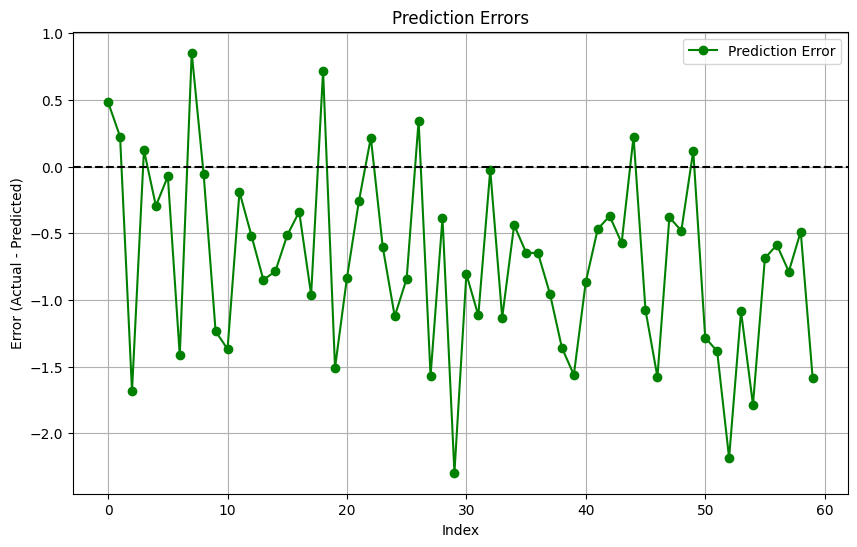

In [27]:
# Visualize the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, label='Prediction Error', color='green', marker='o')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Prediction Errors')
plt.legend()
plt.grid(True)
plt.show()